In [15]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE

In [18]:
# Read the raw database that was created in the bleaching_statistics.py script
db = pd.read_json('raw_data_window_10.json')
db.head()

,lat,lng,month,raw_chlor_a_aqua,raw_chlor_a_seawifs,raw_chlor_a_terra,raw_salinity,raw_sst,raw_sst_whoi,raw_velocity_u,raw_velocity_v,severity,year
0,-21.22,55.22,4,"[0.248802691698074, 0.20917397737503002, 0.132...","[0.06279426068067501, 0.107715182006359, 0.083...","[0.187744826078414, 0.13887885212898202, 0.093...","[15.204, 15.203000000000001, 15.189, 15.179, 1...","[27.25, 27.28, 27.21, 27.11, 27.11, 27.02, 26....","[27.2310791015625, 27.25569725036621, 27.30441...","[-0.088, -0.083, -0.27, -0.117, 0.017, -0.15, ...","[0.09, -0.053, -0.10400000000000001, -0.061, -...",0,2008
1,-21.05,55.23,7,[],[],[],[],[],[],[],[],0,2008
2,-21.16,55.28,2,[],[],[],[],[],[],[],[],0,2008
3,43.00,5.00,8,[],"[0.299542069435119, 0.29057654738426203, 0.283...",[],"[18.016000000000002, 18.067, 18.108, 18.097, 1...","[21.62, 20.990000000000002, 20.79, 20.98, 21.3...","[21.790637969970703, 21.631603240966797, 21.59...","[0.059000000000000004, -0.17300000000000001, -...","[-0.246, -0.548, -0.39, 0.016, -0.012, -0.169,...",-1,1999
4,10.12,99.81,7,"[0.501900017261505, 0.5892923474311821, 0.9793...",[0.8815642595291131],"[1.379987835884094, 1.347643375396728, 2.49852...","[10.487, 10.482000000000001, 10.485, 10.482000...","[29.66, 30.21, 29.8, 29.27, 29.23, 29.15000000...",[],"[0.073, 0.093, 0.121, 0.016, 0.033, 0.061, 0.0...","[0.083, 0.08600000000000001, 0.134, 0.07, 0.06...",0,2009


Define the named variables. These are the human interpretable base forms of the variables of interest rather than the product names. For example, chlor_a rather than `chlor_a_seawifs`.

Each parameter also has min and max parameters for filtering. These values are set by hand based on physically plausible parameters. This is done because the sensed data has anomalous outliers (e.g. wave velocity > 1000m/s).

In [6]:
variables = {
    "sst": {
        "min": 5,
        "max": 50
    },
    "chlor_a": {
        "min": 0,
        "max": 1
    },
    "velocity": {
        "min": 0,
        "max": 50
    },
    "salinity": {
        "min": 0,
        "max": 20
    },
}

The database contains raw data. Here, all columns containing `raw_data`, are processed according to the previously set max and min values to remove outliers. Then, basic statistics for the data are calculated.

Note: I see a potential issue here with velocity measurements. Because those values are signed, a mean value may equal zero, even when that is not characteristic of the average amount of flow.

In [19]:
for variable in db.columns:
    if 'raw_' in variable:
        product = str.split(variable, 'raw_')[1]
        filtered_values = []
        means, meds, mins, maxs, vars = [], [], [], [], []
        for entry in db[variable]:
            for category in variables:
                # Note, this if statement requires that the given name of
                # a variable matches a part of the actual product name
                # Not a great dependency
                if category in product:
                    min = variables[category]['min']
                    max = variables[category]['max']
            filtered_entry = [value for value in entry if value < max and value > min]
            filtered_values.append(filtered_entry)
            
            # Calculate statistics based on the filtered values
            if len(filtered_entry) > 0:
                means.append(np.mean(filtered_entry))
                meds.append(np.median(filtered_entry))
                mins.append(np.min(filtered_entry))
                maxs.append(np.max(filtered_entry))
                vars.append(np.var(filtered_entry))
            else:
                means.append(np.NaN)
                meds.append(np.NaN)
                mins.append(np.NaN)
                maxs.append(np.NaN)
                vars.append(np.NaN)
        db[product] = filtered_values
        db['mean_' + product] = means
        db['med_' + product] = meds
        db['min_' + product] = mins
        db['max_' + product] = maxs
        db['variance_' + product] = vars

Different sources of information are combined. For example, there are three different sources of chlorophyll a concentration (MODIS-Aqua, MODIS-Terra, and SeaWIFS). The products are assigned a priority. Data from preferred sources is used when multiple sources of data are available.

Note: I should probably do this before the calculation of basic stats

In [20]:
stats = ['mean_', 'med_', 'min_', 'max_', 'variance_']
#stats = ['mean_', 'med_', 'min_', 'max_']
for stat in stats:
    # Merge the multiple sources of chlorophyll a
    # Prefer seawifs, then modis terra, then modis aqua
    db[stat + 'chlor_a'] = db[stat + 'chlor_a_seawifs'].fillna(db[stat + 'chlor_a_terra']).fillna(db[stat + 'chlor_a_aqua'])

    # Merge the multiple sources of temperature
    # Prefer sst WHOI model, then OISST
    db[stat + 'sst'] = db[stat + 'sst_whoi'].fillna(db[stat + 'sst'])

    # combine the current velocity vector into magnitude
    vel_mag = lambda u, v: math.sqrt(u ** 2  + v ** 2)
    db[stat + 'velocity'] = db[stat + 'velocity_u'].combine(db[stat + 'velocity_v'], vel_mag)


# All of the figures!!

In [9]:
colors =['#343754', '#8D99AE', '#D65959', '#C93434', '#AC0808']

### Basic comparison of values between bleaching events, and healthy observations

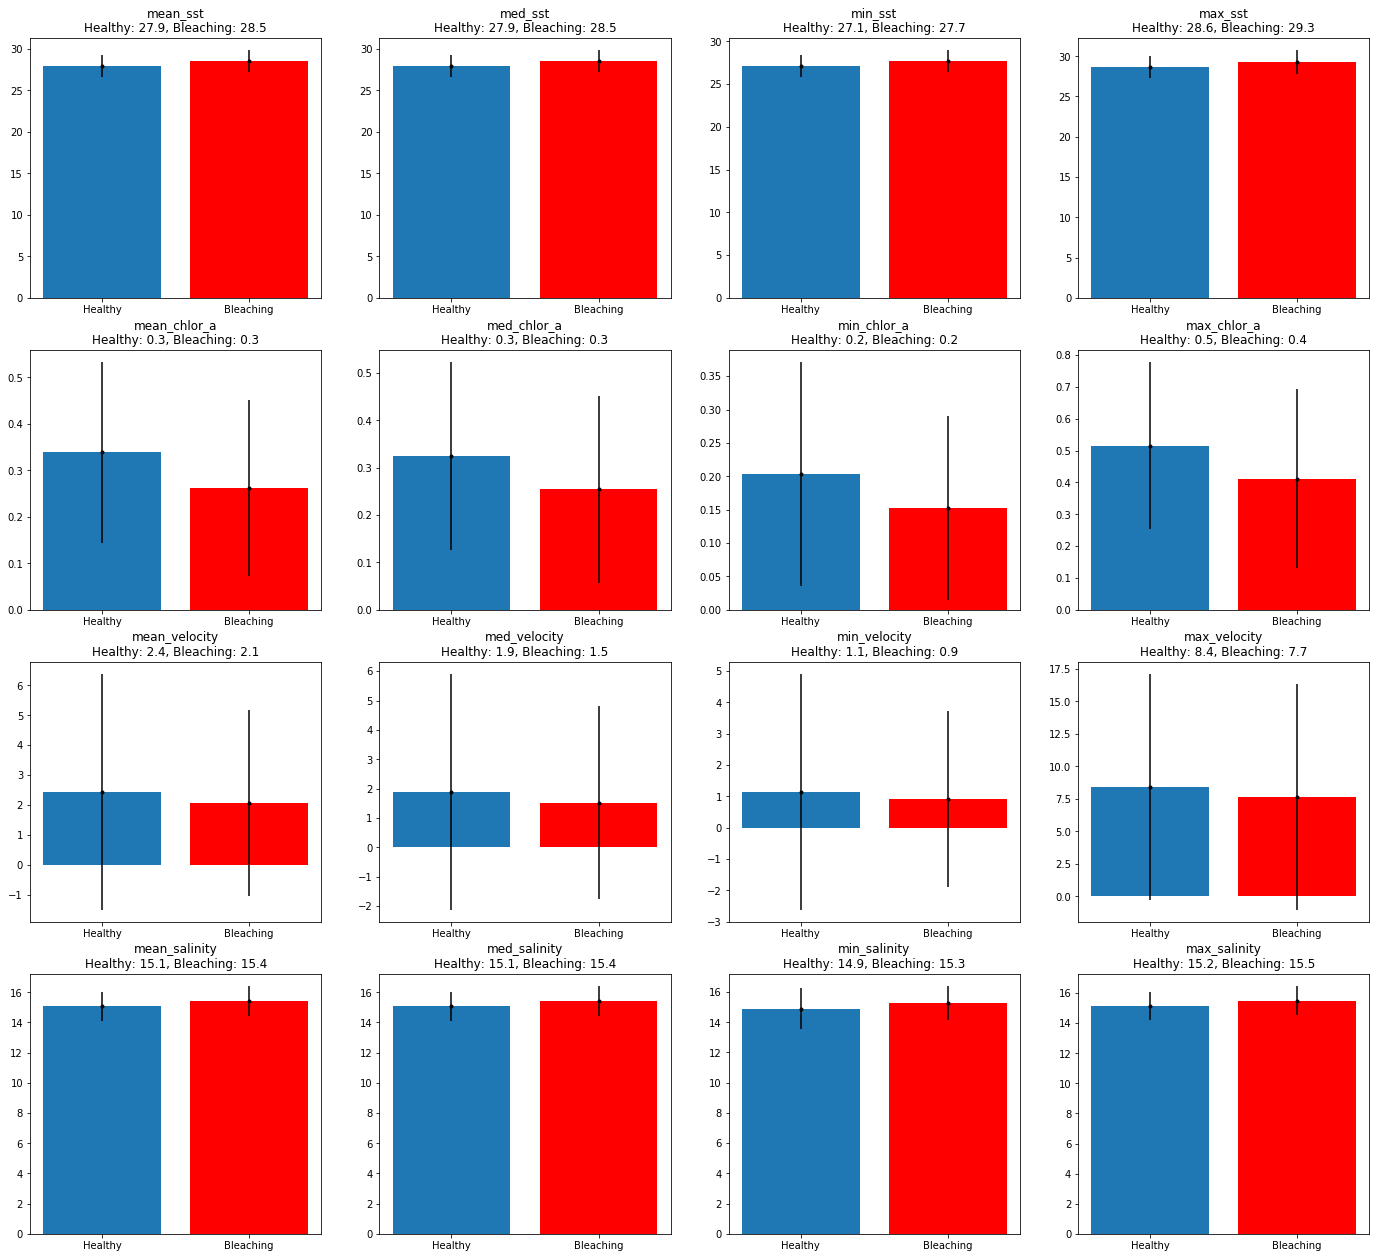

In [10]:
healthy = db[db['severity'] == 0]
bleaching = db[db['severity'] != 0]

counter = 1
plt.figure(figsize=(24, 22))
for variable in variables:
    for stat in stats:
        mean_healthy = healthy[stat + variable].mean()
        var_healthy = math.sqrt(healthy[stat + variable].var())
        mean_bleaching = bleaching[stat + variable].mean()
        var_bleaching = math.sqrt(bleaching[stat + variable].var())
        plt.subplot(4,4,counter)
        plt.errorbar([0, 1], [mean_healthy, mean_bleaching], [var_healthy, var_bleaching], fmt='.', color='black')
        plt.bar(0, mean_healthy)
        plt.bar(1, mean_bleaching, color='r')
        plt.xticks([0, 1], ['Healthy', 'Bleaching'])
        #plt.legend(['Healthy', 'Bleaching'])
        title = str(stat + variable + "\nHealthy: {0:.1f}, Bleaching: {1:.1f}").format(mean_healthy, mean_bleaching)
        plt.title(title)
        counter += 1
#plt.savefig('Mean Value Comparison.png', dpi=600)
plt.show()

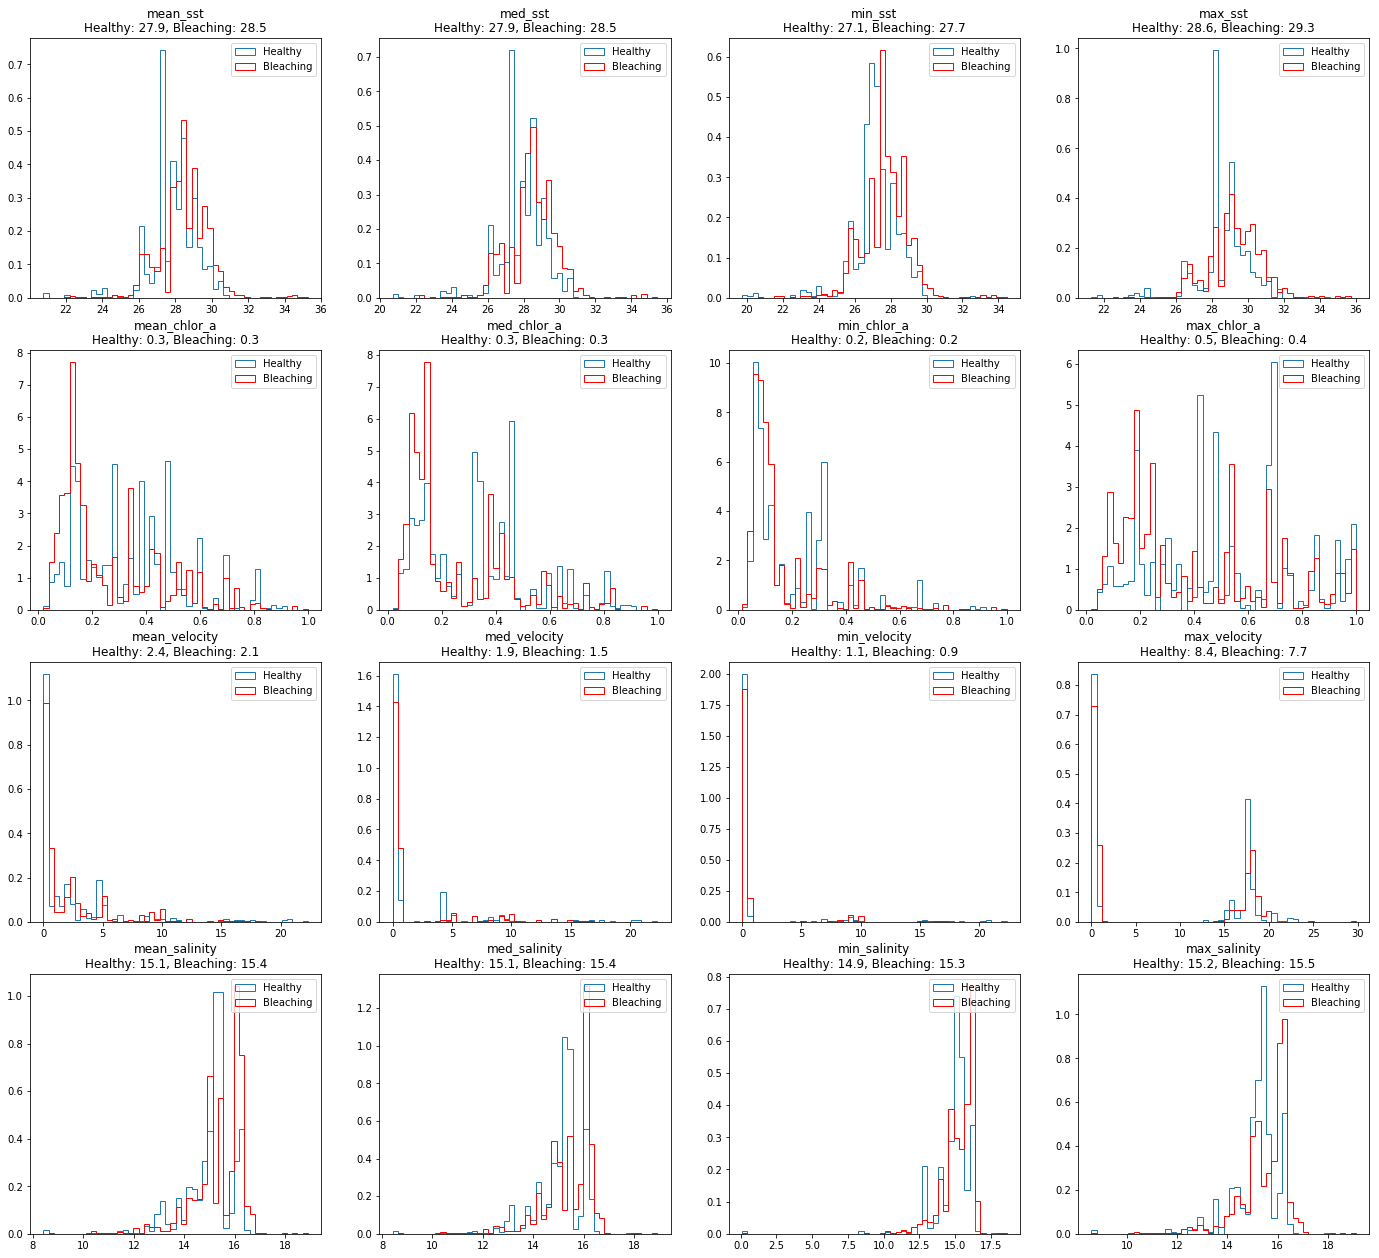

In [11]:
counter = 1
plt.figure(figsize=(24, 22))
for variable in variables:
    for stat in stats:
        val_healthy = healthy[stat + variable].dropna()
        val_bleaching = bleaching[stat + variable].dropna()
        plt.subplot(4,4,counter)
        bins = np.histogram(np.hstack((val_healthy, val_bleaching)), bins=50)[1]
        plt.hist(val_healthy, bins, histtype='step', density=True)
        plt.hist(val_bleaching, bins, color='r', histtype='step', density=True)
        plt.legend(['Healthy', 'Bleaching'])
        title = str(stat + variable + "\nHealthy: {0:.1f}, Bleaching: {1:.1f}").format(np.mean(val_healthy), np.mean(val_bleaching))
        plt.title(title)
        counter += 1
#plt.savefig('Distribution of Mean Values.png', dpi=600)
plt.show()

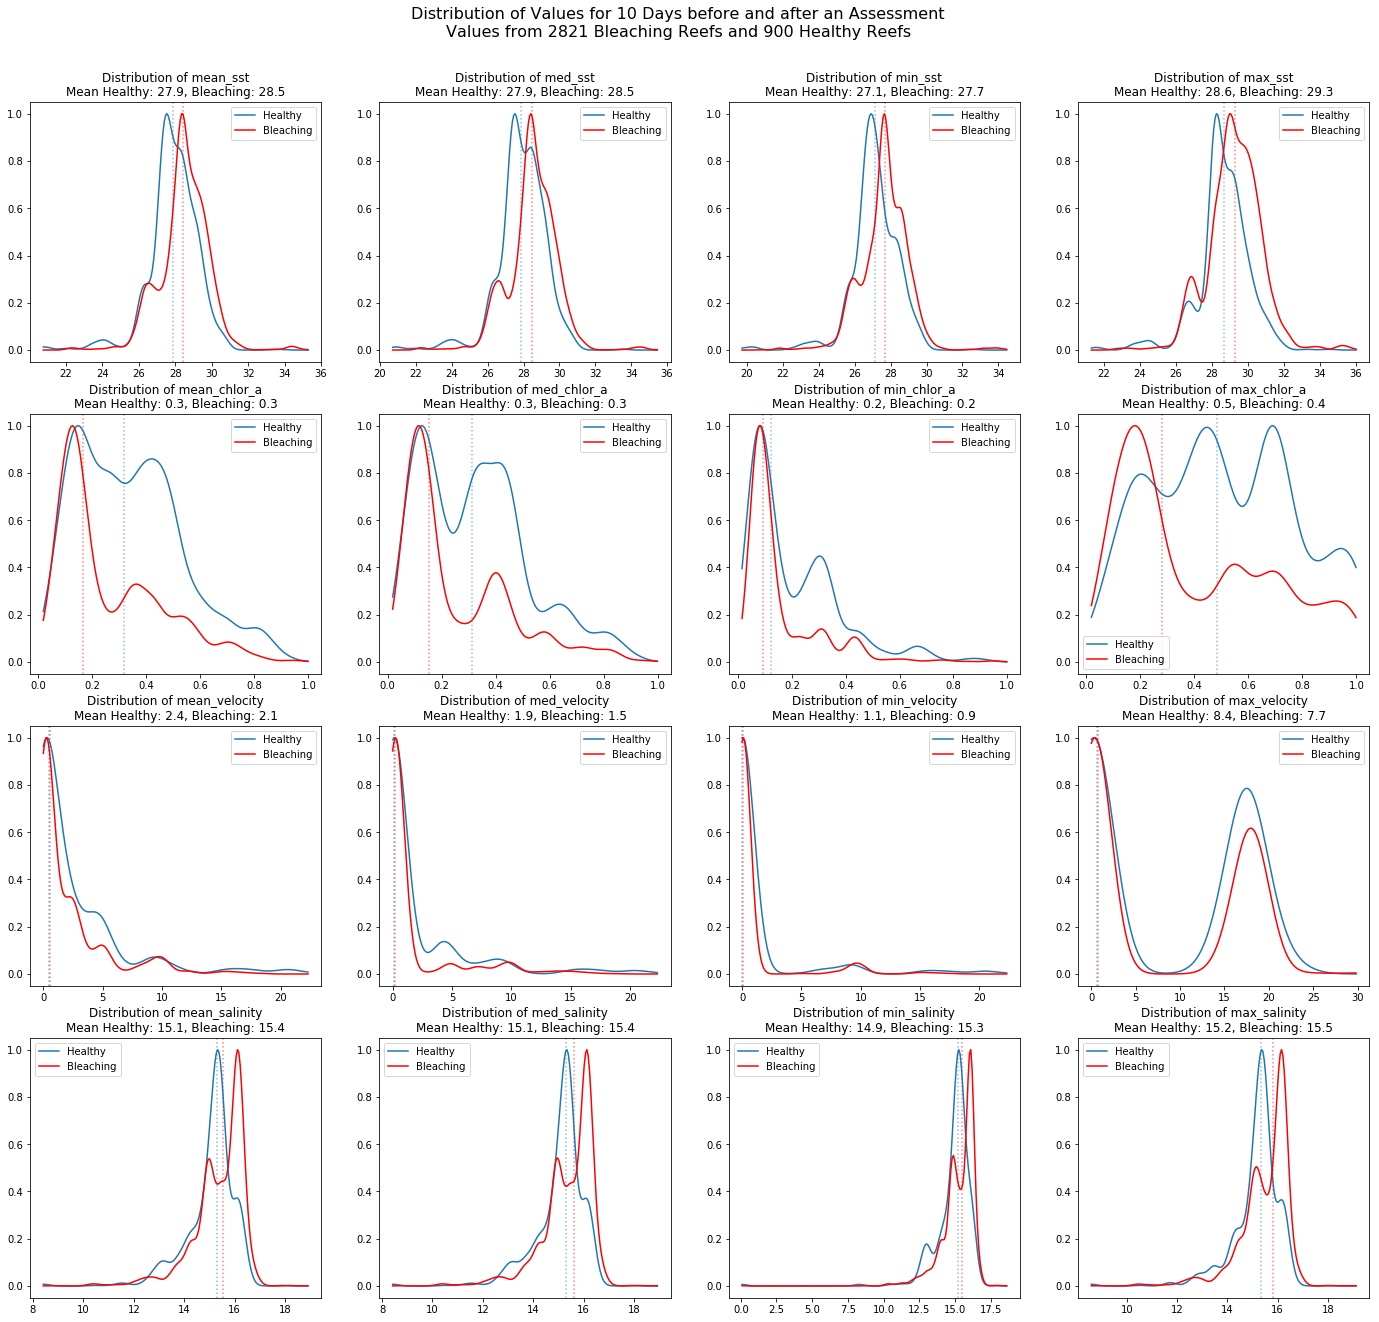

In [12]:
counter = 1
plt.figure(figsize=(24, 22))
for variable in variables:
    for stat in stats:
        val_healthy = healthy[stat + variable].dropna()
        val_bleaching = bleaching[stat + variable].dropna()
        min_val = np.min(pd.concat([val_bleaching, val_healthy]))
        max_val = np.max(pd.concat([val_bleaching, val_healthy]))
        xs = np.linspace(min_val, max_val, 200)

        density_healthy = gaussian_kde(val_healthy)
        density_bleaching = gaussian_kde(val_bleaching)

        median_healthy = np.median(val_healthy)
        median_bleaching = np.median(val_bleaching)
        plt.subplot(4,4,counter)
        plt.plot(xs, density_healthy(xs)/np.max(density_healthy(xs)))
        plt.vlines(median_healthy, -0.05, 1.05, color='C0', alpha = 0.5, linestyle=':')
        plt.vlines(median_bleaching, -0.05, 1.05, color='r', alpha = 0.5, linestyle=':')
        plt.plot(xs, density_bleaching(xs)/np.max(density_bleaching(xs)), color='red')

        plt.ylim([-0.05,1.05])
        plt.legend(['Healthy', 'Bleaching'])
        title = str("Distribution of " + stat + variable + "\nMean Healthy: {0:.1f}, Bleaching: {1:.1f}").format(np.mean(val_healthy), np.mean(val_bleaching))
        plt.title(title)
        counter += 1
plt.suptitle('Distribution of Values for 10 Days before and after an Assessment\nValues from 2821 Bleaching Reefs and 900 Healthy Reefs', size=16, y=0.94)
#plt.savefig('Distributions of Values - Window 10.png', dpi=300)
plt.show()

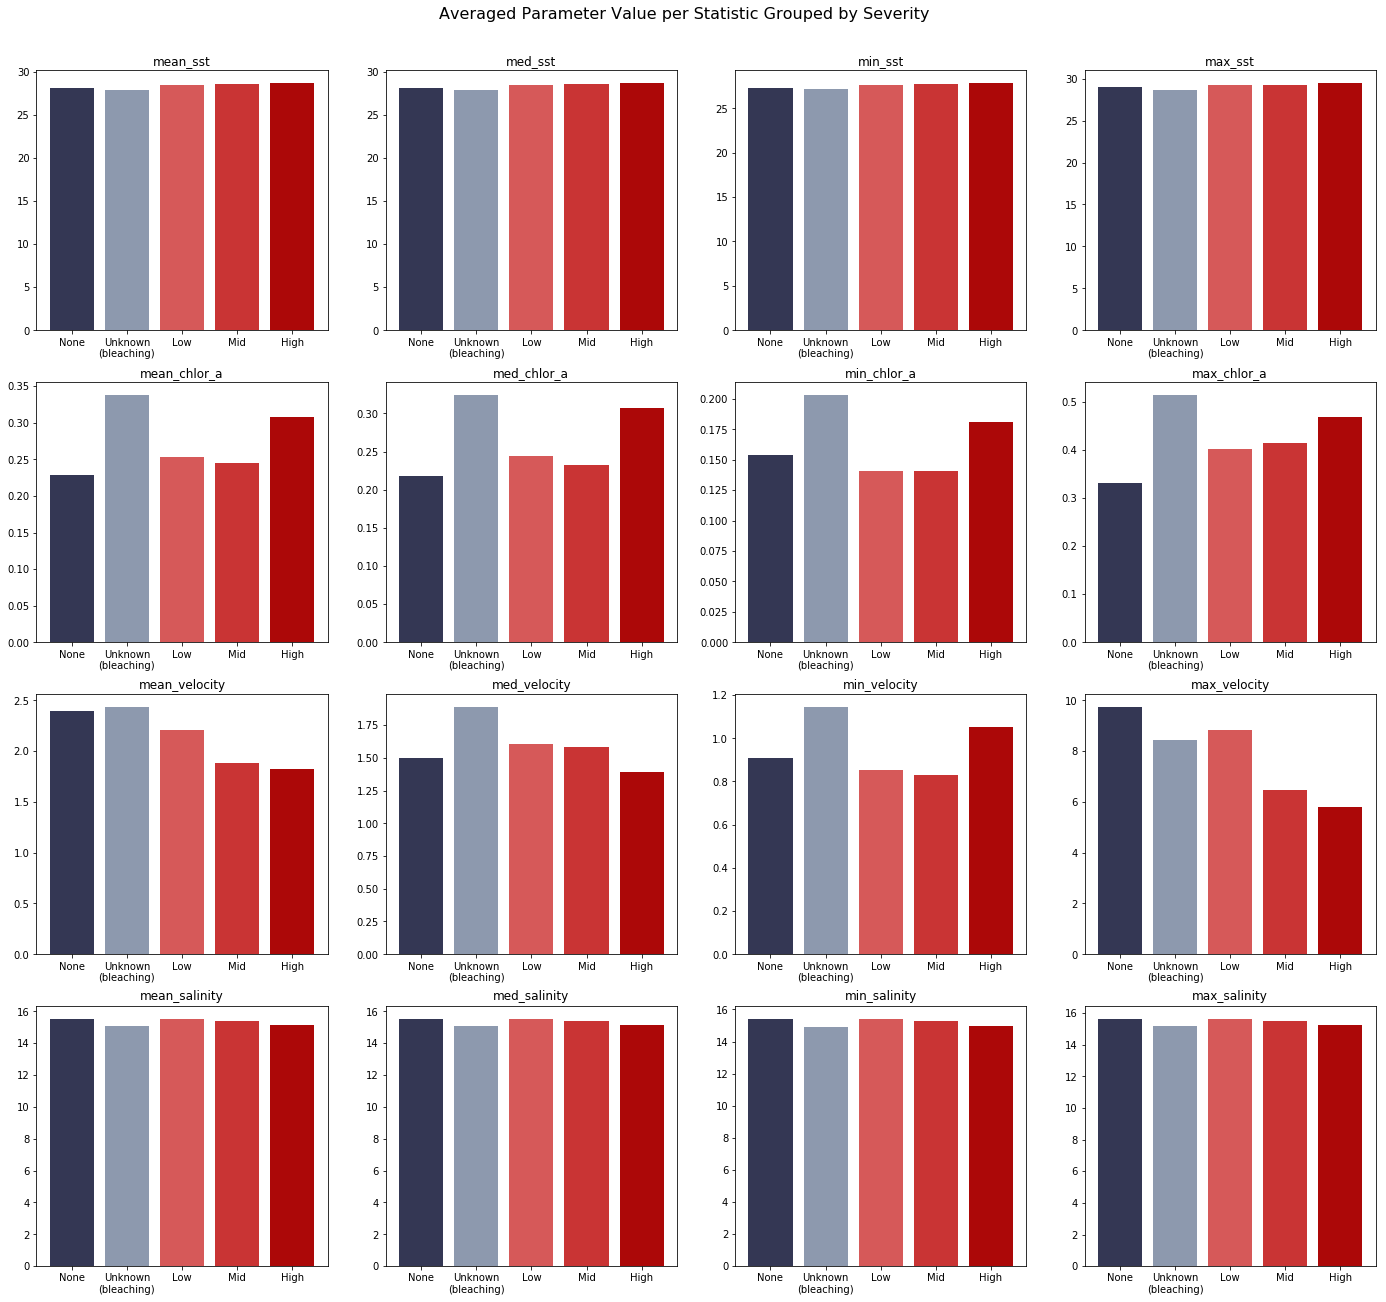

In [13]:
ordered_severity = [0, -1, 1, 2, 3]
counter = 1
plt.figure(figsize=(24, 22))
for variable in variables:
    for stat in stats:
        plt.subplot(4,4,counter)
        for severity in ordered_severity:
            values =  db[db['severity'] == severity]
            mean_val = values[stat + variable].mean()
            #var_val = math.sqrt(values[stat + variable].var())
            #plt.errorbar(severity, mean_val, var_val, fmt='.', color='black')
            plt.bar(severity, mean_val, color=colors[severity+1])
            plt.xticks([-1, 0, 1, 2, 3], ['None', 'Unknown\n(bleaching)', 'Low', 'Mid', 'High'])
            #plt.legend(['Healthy', 'Bleaching'])
            title = str(stat + variable)
            plt.title(title)
        counter += 1
plt.suptitle("Averaged Parameter Value per Statistic Grouped by Severity", size=16, y=0.92)
plt.savefig('Mean Value by Severity - Window 10.png', dpi=300)
plt.show()

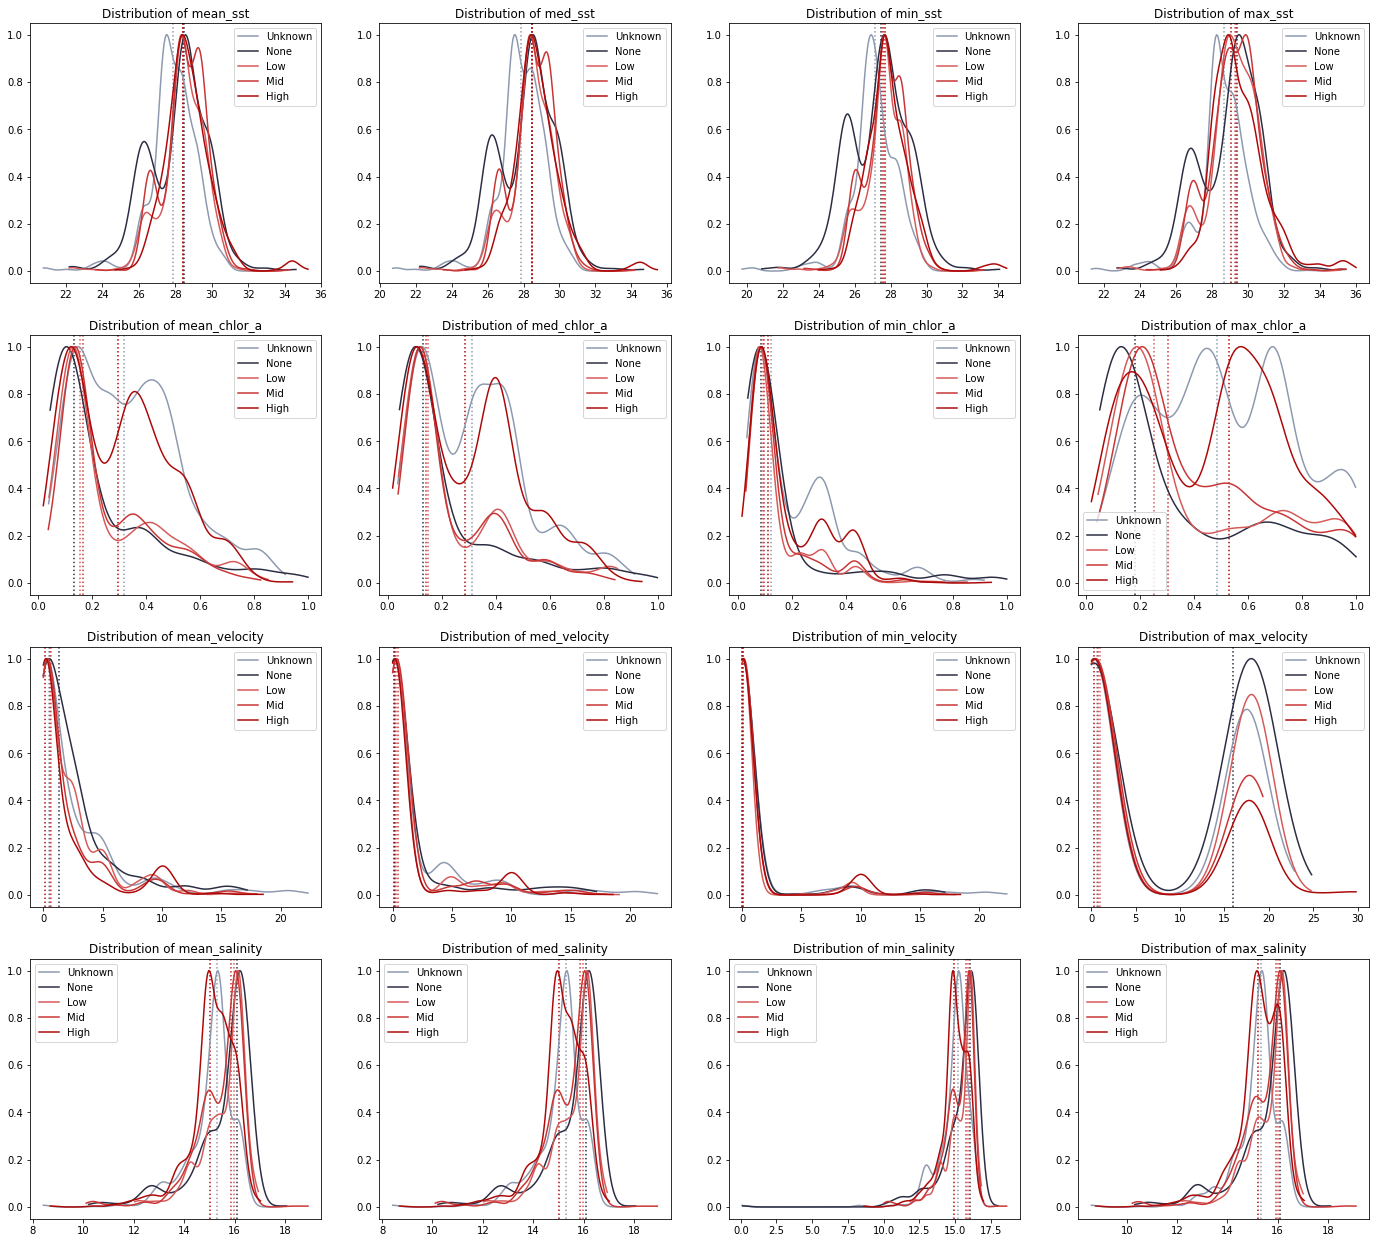

In [14]:
colors =['#2B2D42', '#8D99AE', '#D65959', '#C93434', '#AC0808']
ordered_severity = [0, -1, 1, 2, 3]
counter = 1
plt.figure(figsize=(24, 22))
for variable in variables:
    for stat in stats:
        plt.subplot(4,4,counter)
        for severity in ordered_severity:
            values =  db[db['severity'] == severity]
            val = values[stat + variable].dropna()
            #print("Severity", severity, "Stat", stat + variable, len(val))
            min_val = np.min(val)
            max_val = np.max(val)
            xs = np.linspace(min_val, max_val, 200)

            density = gaussian_kde(val)
            median = np.median(val)

            plt.plot(xs, density(xs)/np.max(density(xs)), color=colors[severity+1])
            plt.vlines(median, -0.05, 1.05, linestyle=':', color=colors[severity+1])
            plt.ylim([-0.05,1.05])
            plt.legend(['Unknown', 'None', 'Low', 'Mid', 'High'])
            title = str("Distribution of " + stat + variable)
            plt.title(title)
        counter += 1
#plt.savefig('Mean Value Comparison.png', dpi=600)
plt.show()

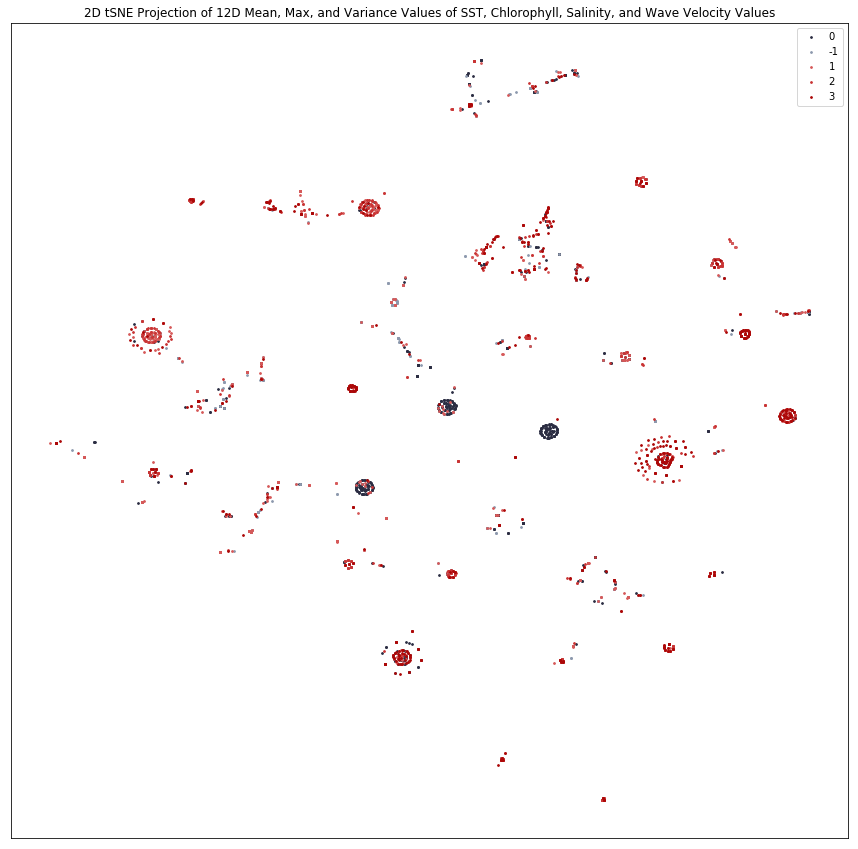

In [21]:
mean_values = []
max_values = []
var_values = []
for variable in variables:
    mean_values.append(db['mean_' + variable])
    max_values.append(db['max_' + variable])
    var_values.append(db['variance_' + variable])
mean_values = np.array(mean_values)
max_values = np.array(mean_values)
var_values = np.array(var_values)

values = np.concatenate([mean_values, max_values, var_values])


filtered_values = []
severities = []
for row in range(values.shape[1]):
    if sum(np.isnan(values[:,row])) == 0:
        filtered_values.append(values[:,row])
        severities.append(db['severity'][row])

filtered_values = np.array(filtered_values)
severities = np.array(severities)
#filtered_values[np.isnan(filtered_values)] = 0


x_tsne = TSNE(learning_rate=100).fit_transform(filtered_values)
x_tsne = np.array(x_tsne)

colors =['#2B2D42', '#8D99AE', '#D65959', '#C93434', '#AC0808']
ordered_severity = [0, -1, 1, 2, 3]
counter = 0
plt.figure(figsize=(15, 15))
for severity in ordered_severity:
    index = severities == severity
    plt.scatter(x_tsne[index,0], x_tsne[index,1], s=3, color=colors[counter])
    counter += 1
plt.legend(ordered_severity)
plt.xticks([])
plt.yticks([])
plt.title('2D tSNE Projection of 12D Mean, Max, and Variance Values of SST, Chlorophyll, Salinity, and Wave Velocity Values')
plt.savefig('tSNE Mean, Max, Variance - Window 10 - No NaNs.png', dpi=300, bbox_inches='tight')
plt.show()